In [1]:
from space_bandits.toy_problem import get_cust_reward, get_customer, get_rewards
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

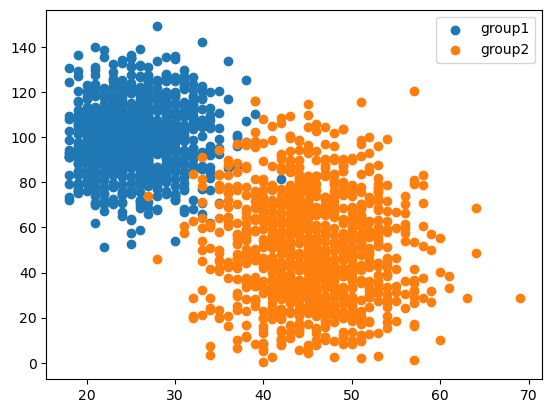

In [2]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1')
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2')
plt.legend()

In [3]:
customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (100000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 2 expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [9.0064 2.504  2.036 ]
group 2 expected rewards: (100000 samples) [ 2.4863  2.4895 20.002 ]


In [4]:
customers

[(2, (52, 61.963776045615965)),
 (2, (47, 33.633372012354016)),
 (2, (47, 38.17044034321838)),
 (2, (42, 59.76857125022345)),
 (2, (41, 68.91150048804516)),
 (2, (39, 78.57276054804372)),
 (2, (47, 42.0837758718048)),
 (2, (39, 58.063490543568726)),
 (2, (38, 72.22141399488766)),
 (2, (43, 73.03437170337028)),
 (2, (46, 98.54900575683993)),
 (2, (48, 55.89940403097817)),
 (2, (43, 87.13369930803486)),
 (2, (46, 85.28791396084661)),
 (2, (54, 100.57700695004527)),
 (2, (44, 47.775524635616705)),
 (2, (46, 72.04238788947194)),
 (2, (46, 38.464735529532156)),
 (2, (43, 76.76647091348458)),
 (2, (44, 28.734769351995823)),
 (2, (47, 69.70999303834482)),
 (2, (39, 44.77950299607505)),
 (2, (39, 25.272932588782197)),
 (2, (42, 50.426223839979784)),
 (2, (47, 43.07129850110627)),
 (2, (44, 45.06930558163957)),
 (2, (53, 62.690525796032816)),
 (2, (42, 55.91895717517982)),
 (2, (36, 47.01854544273633)),
 (2, (41, 64.81201268324321)),
 (2, (54, 50.57792486771316)),
 (2, (52, 16.06963306329717)),

In [5]:
rewards

array([[  0,   0,   0],
       [ 10,   0,   0],
       [  0,   0,   0],
       ...,
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,  25, 100]])

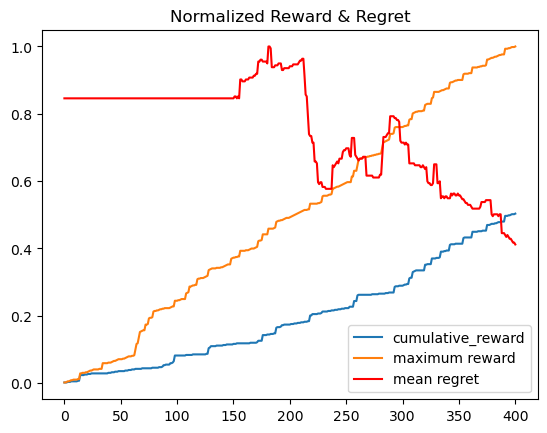

In [6]:
from space_bandits import LinearBandits

num_actions = 3
num_features = 2

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_chioices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    # these will trach values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start + steps):
        records['timesteps'].append(i)
        # generate a customer
        cust = get_customer()
        # generate customer decisions  based on group
        reward_vec = get_rewards(cust)
        # prepare features for model
        context = np.array(cust[1])
        best_choice = optimal_chioices[cust[0]]
        # get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        action = model.action(context)
        # get reward for the action chosen by model
        reward = reward_vec[action]
        # regret is the oppotunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        # plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative_reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)

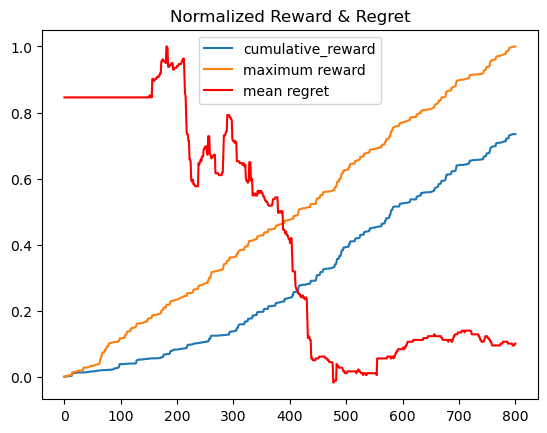

In [7]:
# from space_bandits import load_model
# linear_model.save('data/less9/test_path.pkl')

# continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

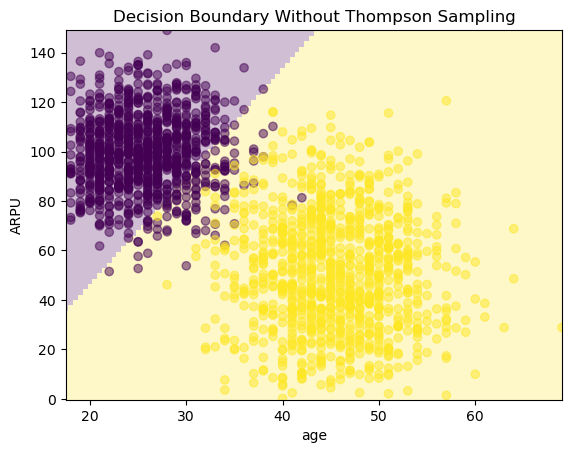

TypeError: 'NoneType' object is not subscriptable

In [10]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    # model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    # plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


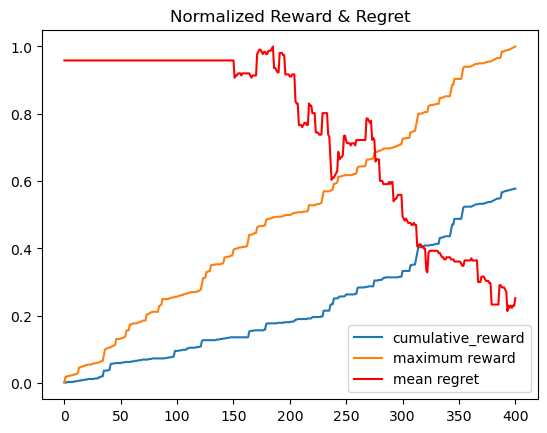

In [11]:
from space_bandits import NeuralBandits

num_actions = 3
num_features = 2
memory_size = 10000

neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

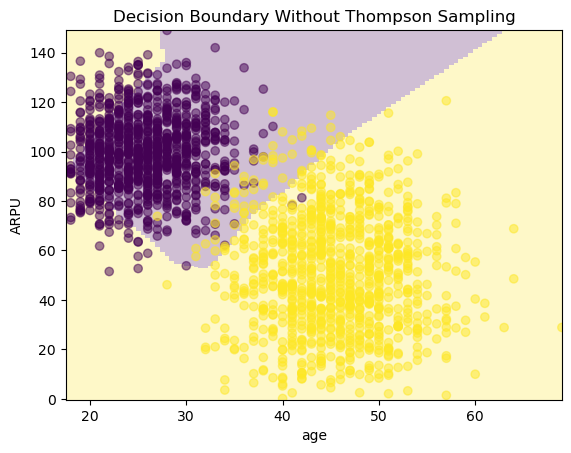

TypeError: 'NoneType' object is not subscriptable

In [12]:
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling', n_threads=3)


t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

In [16]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("data/less9/Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [17]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy